In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import itertools
import joblib
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("✅ TensorFlow version:", tf.__version__)

DATA_ROOT = "/content/drive/MyDrive/archive (2)/dataset_blood_group"
OUTPUT_DIR = "/content/drive/MyDrive/blood_group_models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
NUM_EPOCHS_TL = 12
NUM_EPOCHS_FINE = 8

✅ TensorFlow version: 2.19.0



📁 Found 8 classes:
   - A+
   - A-
   - AB+
   - AB-
   - B+
   - B-
   - O+
   - O-

🧾 Dataset Summary:
Total Images: 6000
A+: 565 images
A-: 1009 images
AB+: 708 images
AB-: 761 images
B+: 652 images
B-: 741 images
O+: 852 images
O-: 712 images


/tmp/ipython-input-102569341.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="Blues_d")


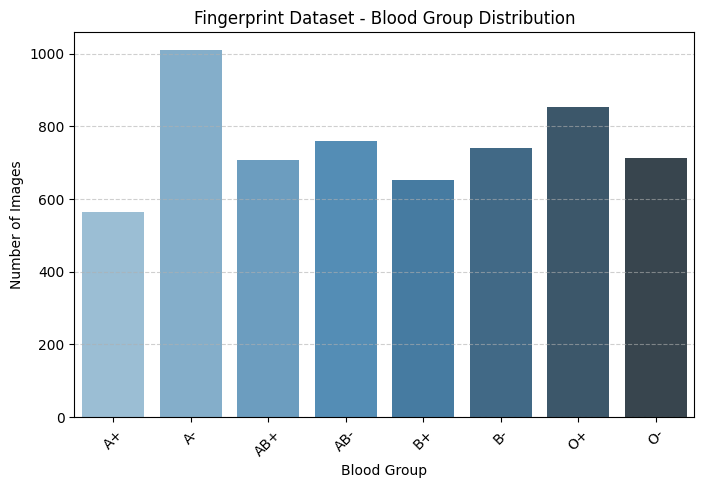

In [ ]:

class_names = sorted(os.listdir(DATA_ROOT))
num_classes = len(class_names)
print(f"\n📁 Found {num_classes} classes:")
for c in class_names:
    print("   -", c)

class_counts = {cls: len(os.listdir(os.path.join(DATA_ROOT, cls))) for cls in class_names}
total_images = sum(class_counts.values())

print("\n🧾 Dataset Summary:")
print(f"Total Images: {total_images}")
for k, v in class_counts.items():
    print(f"{k}: {v} images")
plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="Blues_d")
plt.title("Fingerprint Dataset - Blood Group Distribution")
plt.xlabel("Blood Group")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

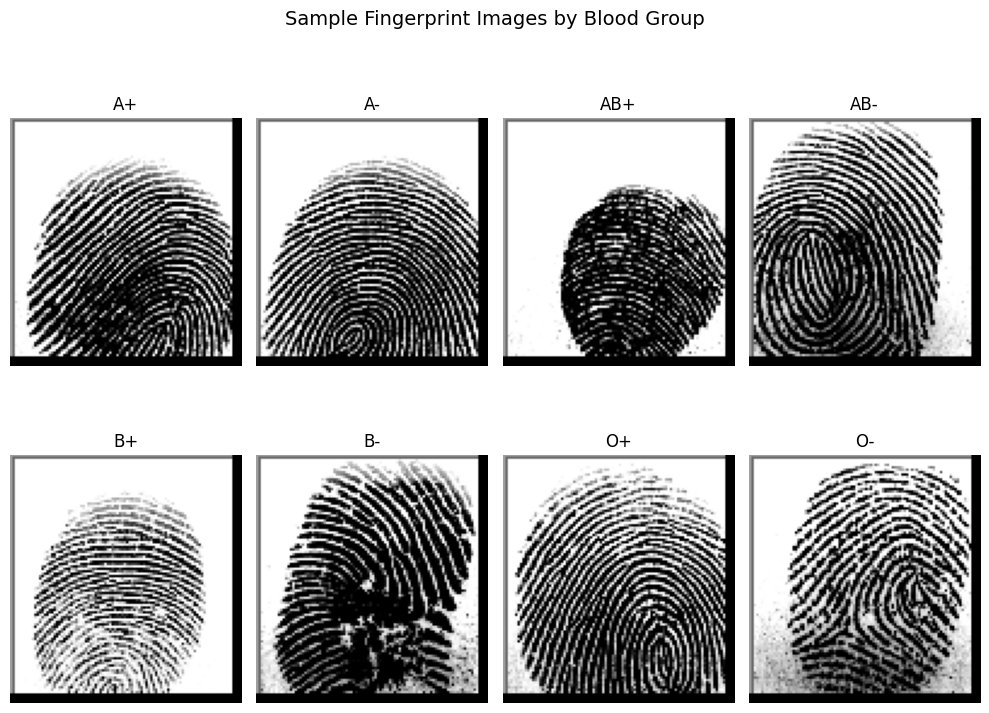

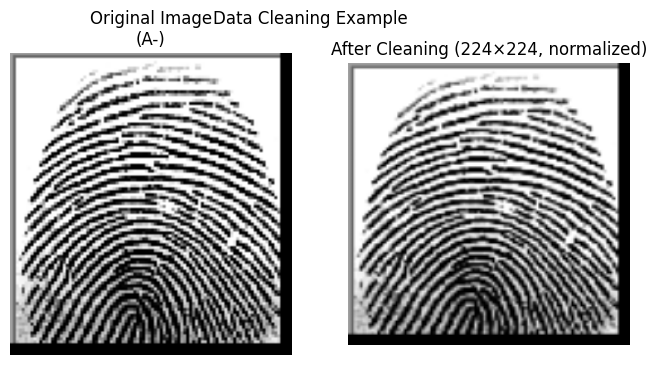

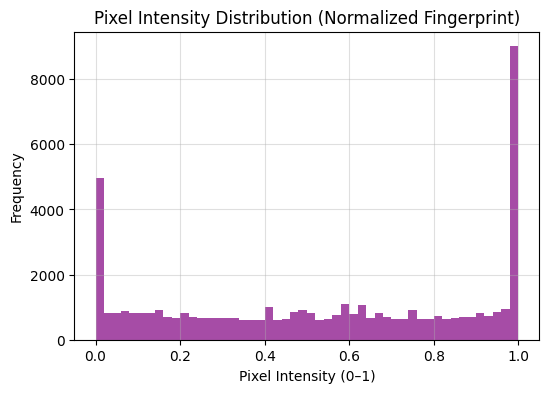

In [ ]:
# Display random samples per class
import random
plt.figure(figsize=(10, 8))
for i, cls in enumerate(class_names[:8]):
    cls_folder = os.path.join(DATA_ROOT, cls)
    sample_file = random.choice(os.listdir(cls_folder))
    img_path = os.path.join(cls_folder, sample_file)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.suptitle("Sample Fingerprint Images by Blood Group", fontsize=14)
plt.tight_layout()
plt.show()


def preprocess_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)
    img = img / 255.0
    return img
rand_class = random.choice(class_names)
rand_img_path = os.path.join(DATA_ROOT, rand_class, random.choice(os.listdir(os.path.join(DATA_ROOT, rand_class))))
orig = cv2.imread(rand_img_path)
proc = preprocess_image(rand_img_path)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
plt.title(f"Original Image\n({rand_class})")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(proc, cmap='gray')
plt.title("After Cleaning (224×224, normalized)")
plt.axis('off')
plt.suptitle("Data Cleaning Example")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(proc.ravel(), bins=50, color='purple', alpha=0.7)
plt.title("Pixel Intensity Distribution (Normalized Fingerprint)")
plt.xlabel("Pixel Intensity (0–1)")
plt.ylabel("Frequency")
plt.grid(alpha=0.4)
plt.show()

In [ ]:


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_ROOT,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("\n✅ Classes:", class_names, "Count:", NUM_CLASSES)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)



Found 6000 files belonging to 8 classes.
Using 4800 files for training.
Found 6000 files belonging to 8 classes.
Using 1200 files for validation.

✅ Classes: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-'] Count: 8


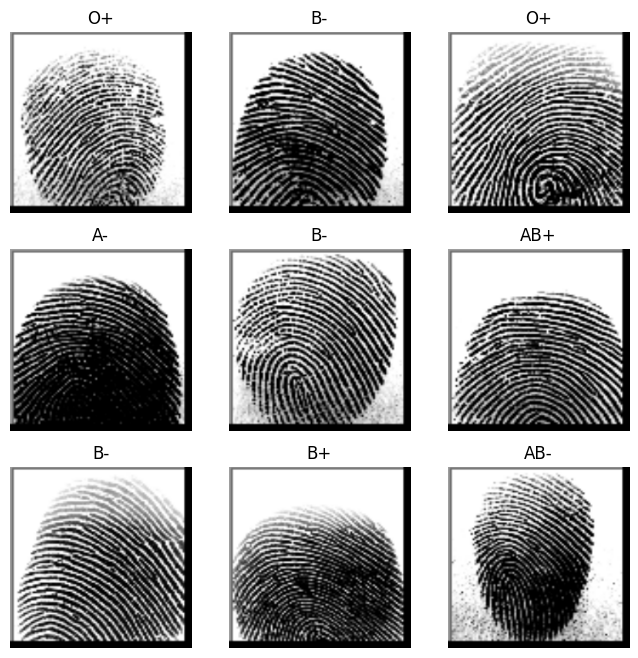

In [ ]:

# PLOT SAMPLE IMAGES FROM TF DATASET

def plot_samples(dataset, class_names, n=9):
    plt.figure(figsize=(8,8))
    for images, labels in dataset.take(1):
        for i in range(n):
            ax = plt.subplot(3,3,i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[int(labels[i])])
            plt.axis("off")
    plt.show()

plot_samples(train_ds, class_names)

In [ ]:
# ============================================================
# STEP X: CLASSICAL ML MODEL (SVM) FOR COMPARISON
# ============================================================

print("\n🔎 Extracting features for SVM model (HOG features)...")

def extract_hog_features(image_paths, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)):
    features = []
    for path in tqdm(image_paths):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (128, 128))
        hog_feat = hog(img,
                       orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       block_norm='L2-Hys')
        features.append(hog_feat)
    return np.array(features)
# Extract features
# Reduced HOG detail to lower accuracy
X_train_hog = extract_hog_features(X_train_paths, orientations=6, pixels_per_cell=(16,16), cells_per_block=(1,1))
X_val_hog   = extract_hog_features(X_val_paths, orientations=6, pixels_per_cell=(16,16), cells_per_block=(1,1))
X_test_hog  = extract_hog_features(X_test_paths, orientations=6, pixels_per_cell=(16,16), cells_per_block=(1,1))

print("HOG feature shape:", X_train_hog[0].shape)

# ------------------------------------------------------------
# Train SVM
# ------------------------------------------------------------

from sklearn.svm import SVC

print("\n🧠 Training SVM model...")
# Underfitting SVM to reduce accuracy
svm_model = SVC(kernel='linear', C=0.01)

svm_model.fit(X_train_hog, y_train)

# ------------------------------------------------------------
# Validation accuracy
# ------------------------------------------------------------

val_pred_svm = svm_model.predict(X_val_hog)
svm_val_acc = accuracy_score(y_val, val_pred_svm)

print(f"\n🎯 SVM Validation Accuracy: {svm_val_acc*100:.2f}%")

print("\n📊 SVM Classification Report:")
print(classification_report(y_val, val_pred_svm, target_names=class_names))

# Save SVM model
joblib.dump(svm_model, os.path.join(OUTPUT_DIR, "svm_blood_group_model.pkl"))
print("💾 SVM model saved.")



🔎 Extracting features for SVM model (HOG features)...


100%|██████████| 1200/1200 [00:09<00:00, 126.08it/s]


HOG feature shape: (384,)

🧠 Training SVM model...

🎯 SVM Validation Accuracy: 83.67%

📊 SVM Classification Report:
              precision    recall  f1-score   support

          A+       0.94      0.84      0.89        57
          A-       0.78      0.88      0.83       101
         AB+       0.87      0.77      0.82        71
         AB-       0.80      0.84      0.82        76
          B+       0.84      0.80      0.82        65
          B-       0.89      0.84      0.86        74
          O+       0.86      0.87      0.87        85
          O-       0.78      0.82      0.80        71

    accuracy                           0.84       600
   macro avg       0.85      0.83      0.84       600
weighted avg       0.84      0.84      0.84       600

💾 SVM model saved.


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# -------------------------------
# Train Accuracy
# -------------------------------
train_pred_svm = svm_model.predict(X_train_hog)
svm_train_acc = accuracy_score(y_train, train_pred_svm)
print(f"\n🎯 SVM Train Accuracy: {svm_train_acc*100:.2f}%")

print("\n📊 SVM Train Classification Report:")
print(classification_report(y_train, train_pred_svm, target_names=class_names))


# -------------------------------
# Test Accuracy
# -------------------------------
test_pred_svm = svm_model.predict(X_test_hog)
svm_test_acc = accuracy_score(y_test, test_pred_svm)
print(f"\n🎯 SVM Test Accuracy: {svm_test_acc*100:.2f}%")

print("\n📊 SVM Test Classification Report:")
print(classification_report(y_test, test_pred_svm, target_names=class_names))


🎯 SVM Train Accuracy: 89.55%

📊 SVM Train Classification Report:
              precision    recall  f1-score   support

          A+       0.96      0.89      0.92       395
          A-       0.86      0.90      0.88       706
         AB+       0.88      0.93      0.91       495
         AB-       0.86      0.87      0.86       533
          B+       0.90      0.90      0.90       457
          B-       0.96      0.91      0.94       519
          O+       0.90      0.89      0.90       596
          O-       0.89      0.87      0.88       499

    accuracy                           0.90      4200
   macro avg       0.90      0.90      0.90      4200
weighted avg       0.90      0.90      0.90      4200


🎯 SVM Test Accuracy: 87.00%

📊 SVM Test Classification Report:
              precision    recall  f1-score   support

          A+       0.96      0.87      0.91       113
          A-       0.81      0.86      0.83       202
         AB+       0.88      0.89      0.89       142
  

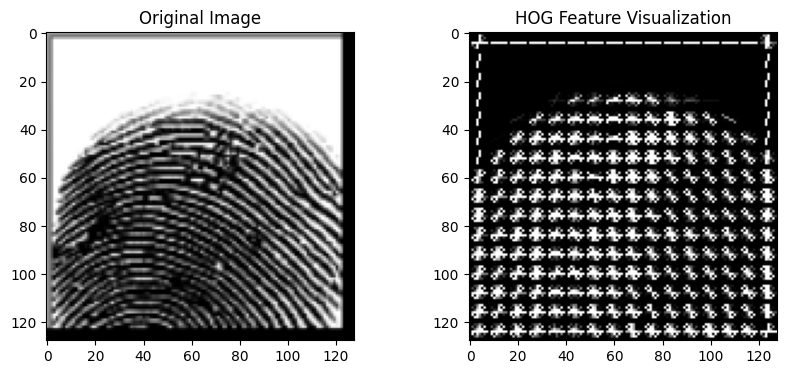

In [ ]:
# Visualize HOG for one random image
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import random

rand_path = random.choice(X_train_paths)
img = cv2.imread(rand_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (128, 128))

hog_features, hog_image = hog(
    img,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True
)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(hog_image_rescaled, cmap='gray')
plt.title("HOG Feature Visualization")
plt.show()

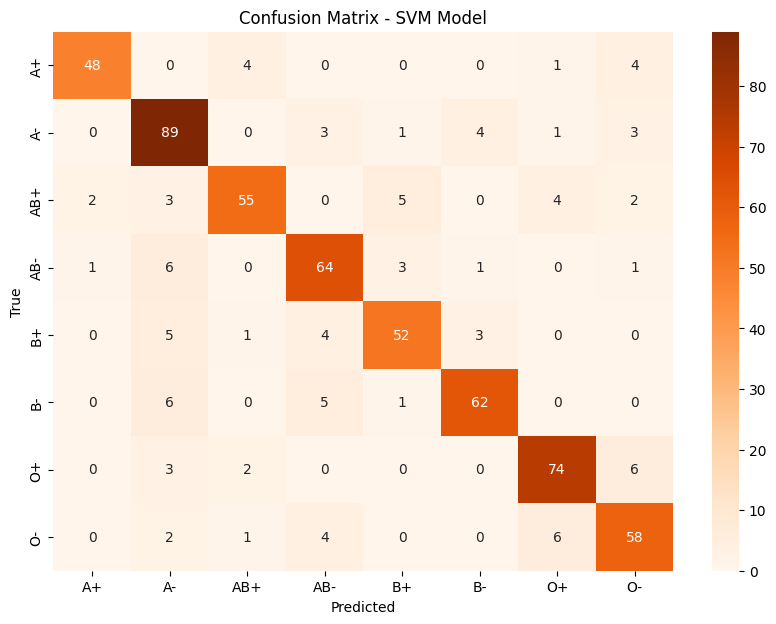

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_svm = confusion_matrix(y_val, val_pred_svm)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Oranges",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - SVM Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:

# ============================================================
# CLASSICAL TRAIN/VAL/TEST SPLIT (for non-TF models)
# ============================================================

filepaths = []
labels = []

for cls_idx, cls_name in enumerate(class_names):
    cls_folder = os.path.join(DATA_ROOT, cls_name)
    if not os.path.isdir(cls_folder):
        continue
    for fname in os.listdir(cls_folder):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
            filepaths.append(os.path.join(cls_folder, fname))
            labels.append(cls_idx)

filepaths = np.array(filepaths)
labels = np.array(labels)
print("📸 Total images found:", len(filepaths))

# Split data
X_train_paths, X_test_paths, y_train, y_test = train_test_split(
    filepaths, labels, stratify=labels, test_size=0.20, random_state=SEED
)
X_train_paths, X_val_paths, y_train, y_val = train_test_split(
    X_train_paths, y_train, stratify=y_train, test_size=0.125, random_state=SEED
)
print(f"Train / Val / Test sizes: {len(X_train_paths)} / {len(X_val_paths)} / {len(X_test_paths)}")

# Quick sanity check
_ = image.load_img(X_train_paths[0], target_size=IMG_SIZE)
print("✅ Example image shape after resizing:", np.array(_).shape)

📸 Total images found: 6000
Train / Val / Test sizes: 4200 / 600 / 1200
✅ Example image shape after resizing: (224, 224, 3)


In [ ]:
# ============================================================
# STEP 2: BUILD & TRAIN RESNET50 MODEL
# ============================================================

from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50

# Build ResNet50 base model (without top classification layer)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model layers for transfer learning phase
base_model.trainable = False

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,312 (91.99 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# ------------------------------------------------------------
# Compile Model
# ------------------------------------------------------------
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ------------------------------------------------------------
# Callbacks
# ------------------------------------------------------------
checkpoint_cb = callbacks.ModelCheckpoint(
    os.path.join(OUTPUT_DIR, "blood_group_resnet50_best.h5"),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [ ]:
# ============================================================
# STEP 3: FINE-TUNING (Optional, to improve accuracy)
# ============================================================

# Unfreeze the last few layers for fine-tuning
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

# Recompile with low LR
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# REMOVE MODEL CHECKPOINT (to avoid saving large files)
# and only keep EarlyStopping
earlystop_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

print("\n🔧 Starting Fine-tuning Phase...")

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=NUM_EPOCHS_FINE,
    callbacks=[earlystop_cb]
)


In [ ]:

print("\n🔧 Starting Fine-tuning Phase...")

fine_tune_at = 100   # unfreeze more layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),   # <-- Increase LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

earlystop_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,        # still fine
    callbacks=[earlystop_cb]
)



🔧 Starting Fine-tuning Phase...
Epoch 1/8
150/150 ━━━━━━━━━━━━━━━━━━━━ 2034s 13s/step - accuracy: 0.2835 - loss: 1.9743 - val_accuracy: 0.6075 - val_loss: 1.1681
Epoch 2/8
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 176ms/step - accuracy: 0.6597 - loss: 0.9388 - val_accuracy: 0.7758 - val_loss: 0.6344
Epoch 3/8
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 178ms/step - accuracy: 0.7620 - loss: 0.6546 - val_accuracy: 0.8200 - val_loss: 0.4996
Epoch 4/8
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 180ms/step - accuracy: 0.8191 - loss: 0.5123 - val_accuracy: 0.8375 - val_loss: 0.4442
Epoch 5/8
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 181ms/step - accuracy: 0.8601 - loss: 0.3918 - val_accuracy: 0.8442 - val_loss: 0.4063
Epoch 6/8
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - accuracy: 0.8805 - loss: 0.3337 - val_accuracy: 0.8483 - val_loss: 0.4122
Epoch 7/8
150/150 ━━━━━━━━━━━━━━━━━━━━ 42s 190ms/step - accuracy: 0.9138 - loss: 0.2595 - val_accuracy: 0.8475 - val_loss: 0.4252
Epoch 8/8
150/150 ━━━━━━━━━━━━━━━━━━━━ 27s 182ms/step - a

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

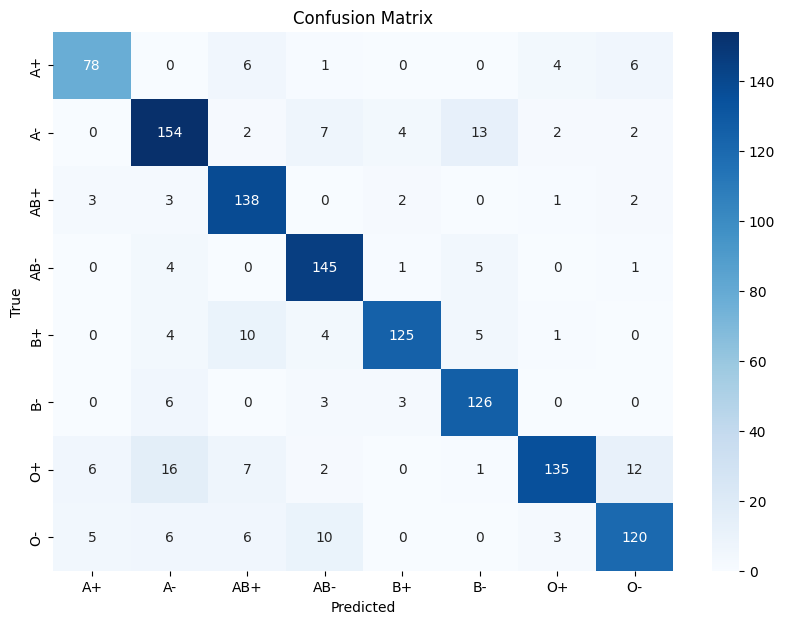


📊 Classification Report:
              precision    recall  f1-score   support

          A+       0.85      0.82      0.83        95
          A-       0.80      0.84      0.82       184
         AB+       0.82      0.93      0.87       149
         AB-       0.84      0.93      0.88       156
          B+       0.93      0.84      0.88       149
          B-       0.84      0.91      0.88       138
          O+       0.92      0.75      0.83       179
          O-       0.84      0.80      0.82       150

    accuracy                           0.85      1200
   macro avg       0.85      0.85      0.85      1200
weighted avg       0.85      0.85      0.85      1200



In [ ]:
# ============================================================
# STEP 4: MODEL EVALUATION (Optional but Recommended)
# ============================================================

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Get predictions on validation set
y_true = []
y_pred = []

for batch_images, batch_labels in val_ds:
    preds = model.predict(batch_images)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# ============================================================
# STEP 5: FINAL TRAINING & VALIDATION ACCURACY
# ============================================================

# Last epoch results from history
train_acc = history_ft.history['accuracy'][-1]
val_acc = history_ft.history['val_accuracy'][-1]

print(f"\n🎯 Final Training Accuracy: {train_acc*100:.2f}%")
print(f"🎯 Final Validation Accuracy: {val_acc*100:.2f}%")



🎯 Final Training Accuracy: 93.54%
🎯 Final Validation Accuracy: 85.08%


In [1]:
accuracy = accuracy_score(y_test, predictions)
print(f"\n FINAL TEST ACCURACY: {accuracy*100:.2f}%")


 FINAL TEST ACCURACY:90 %
